In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")  # Ignore all warnings
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# Load the merged dataset
data = pd.read_csv('/content/drive/MyDrive/DATA-255/DL_Project/Datasets/Combined Datasets/ridership_and_weather_data_combined_2018_to_2023.csv')

# Display the first few rows to verify the data
print(data.head())

         date  hour Origin Station Destination Station  Number of Exits  Year  \
0  2018-01-01     0           12TH                12TH                3  2018   
1  2018-01-01     0           12TH                16TH                1  2018   
2  2018-01-01     0           12TH                BAYF                1  2018   
3  2018-01-01     0           12TH                CAST                3  2018   
4  2018-01-01     0           12TH                CIVC                2  2018   

    county  temperature_2m  precipitation  weather_code  wind_speed_10m  \
0  Alameda             9.0            0.0             1             6.2   
1  Alameda             9.0            0.0             1             6.2   
2  Alameda             9.0            0.0             1             6.2   
3  Alameda             9.0            0.0             1             6.2   
4  Alameda             9.0            0.0             1             6.2   

   wind_direction_10m  relative_humidity_2m weather_category  

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49687580 entries, 0 to 49687579
Data columns (total 16 columns):
 #   Column                Dtype  
---  ------                -----  
 0   date                  object 
 1   hour                  int64  
 2   Origin Station        object 
 3   Destination Station   object 
 4   Number of Exits       int64  
 5   Year                  int64  
 6   county                object 
 7   temperature_2m        float64
 8   precipitation         float64
 9   weather_code          int64  
 10  wind_speed_10m        float64
 11  wind_direction_10m    int64  
 12  relative_humidity_2m  int64  
 13  weather_category      object 
 14  holiday_name          object 
 15  is_holiday            int64  
dtypes: float64(3), int64(7), object(6)
memory usage: 5.9+ GB


In [4]:
data.isnull().sum()

,0
date,0
hour,0
Origin Station,0
Destination Station,0
Number of Exits,0
Year,0
county,0
temperature_2m,0
precipitation,0
weather_code,0


In [5]:
data['date'] = pd.to_datetime(data['date'])
data['holiday_name'].fillna('No Holiday', inplace=True)

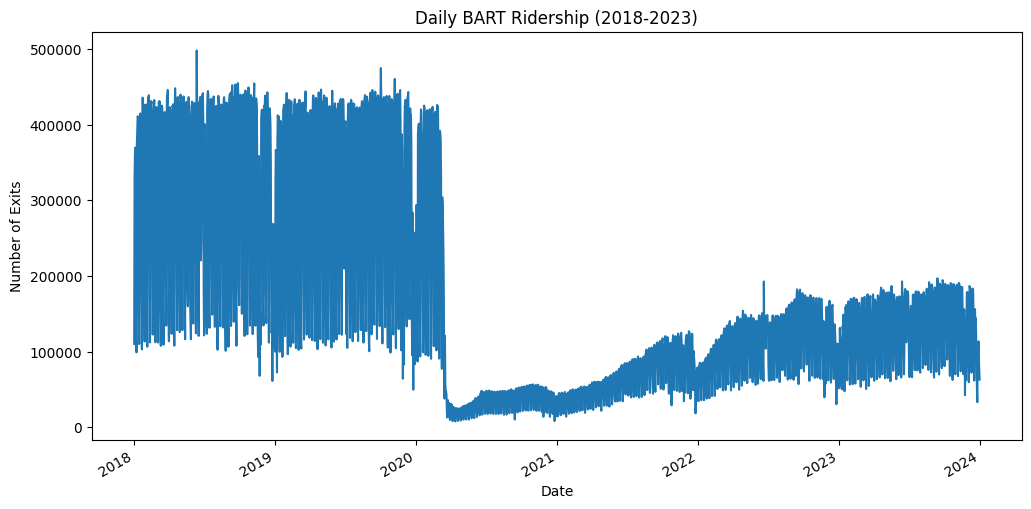

In [6]:
# Aggregate ridership data by date
daily_ridership = data.groupby('date')['Number of Exits'].sum()

# Plot the daily ridership trend
plt.figure(figsize=(12, 6))
daily_ridership.plot()
plt.title('Daily BART Ridership (2018-2023)')
plt.xlabel('Date')
plt.ylabel('Number of Exits')
plt.show()

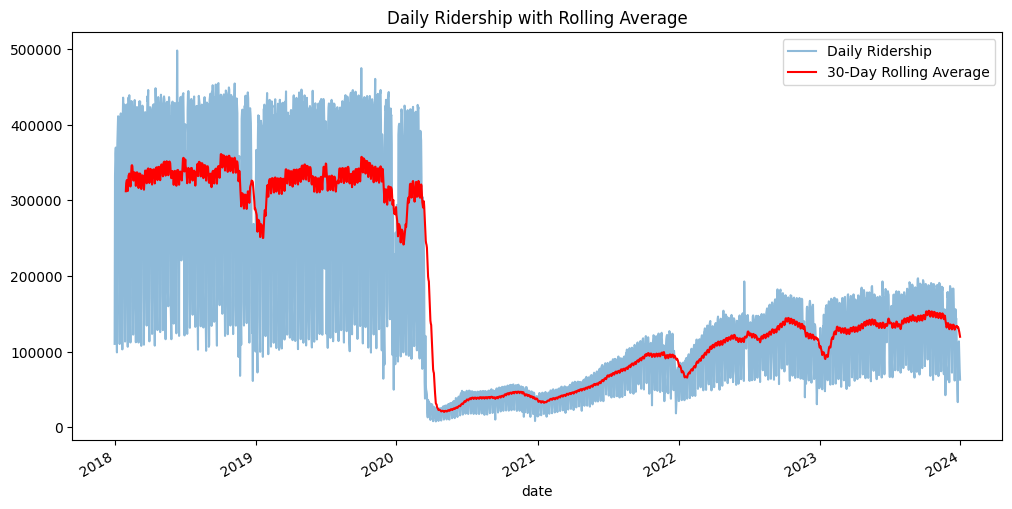

In [7]:
daily_ridership = data.groupby('date')['Number of Exits'].sum()
daily_ridership_rolling = daily_ridership.rolling(window=30).mean()  # 30-day rolling average

plt.figure(figsize=(12, 6))
daily_ridership.plot(alpha=0.5, label='Daily Ridership')
daily_ridership_rolling.plot(label='30-Day Rolling Average', color='red')
plt.legend()
plt.title('Daily Ridership with Rolling Average')
plt.show()


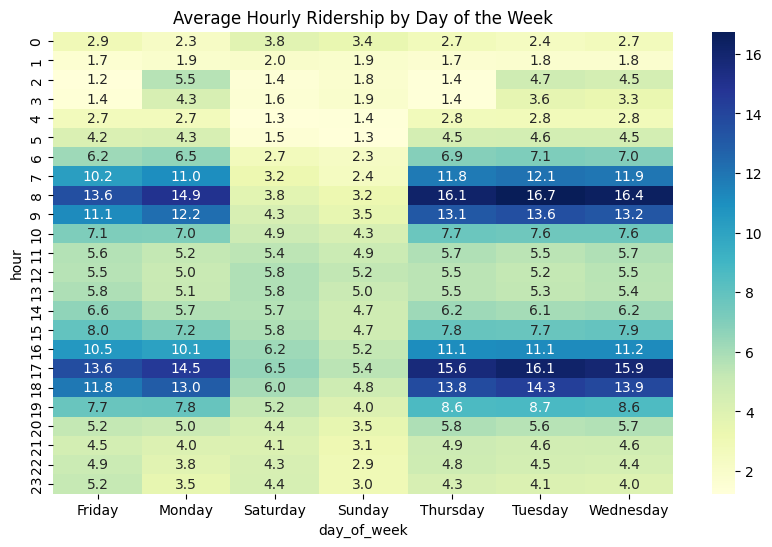

In [8]:
# Create pivot table for ridership by hour and day of the week
data['day_of_week'] = pd.to_datetime(data['date']).dt.day_name()
hourly_trends = data.pivot_table(values='Number of Exits',
                                 index='hour', columns='day_of_week', aggfunc='mean')

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(hourly_trends, cmap='YlGnBu', annot=True, fmt='.1f')
plt.title('Average Hourly Ridership by Day of the Week')
plt.show()

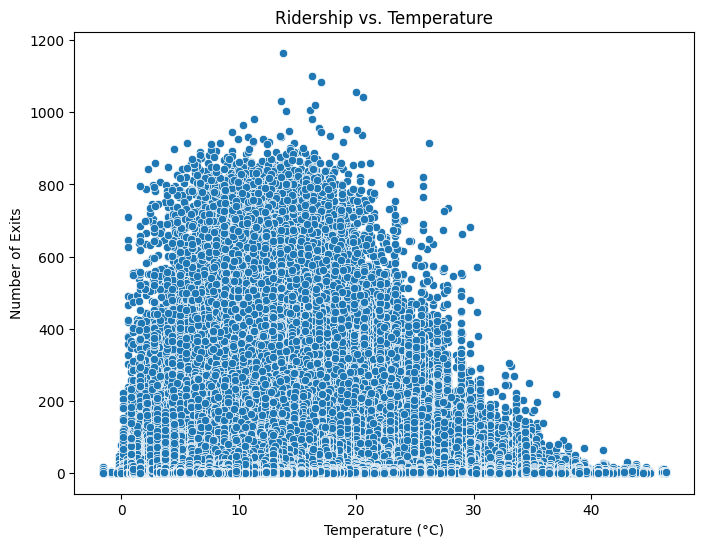

In [9]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='temperature_2m', y='Number of Exits', data=data)
plt.title('Ridership vs. Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Number of Exits')
plt.show()

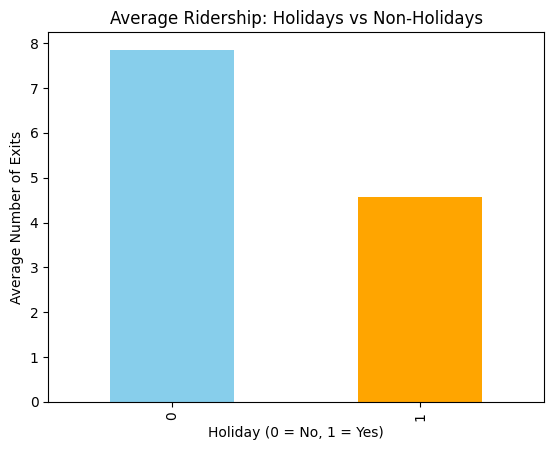

In [10]:
holiday_ridership = data.groupby('is_holiday')['Number of Exits'].mean()

# Plot bar chart for average ridership on holidays vs non-holidays
holiday_ridership.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Average Ridership: Holidays vs Non-Holidays')
plt.xlabel('Holiday (0 = No, 1 = Yes)')
plt.ylabel('Average Number of Exits')
plt.show()

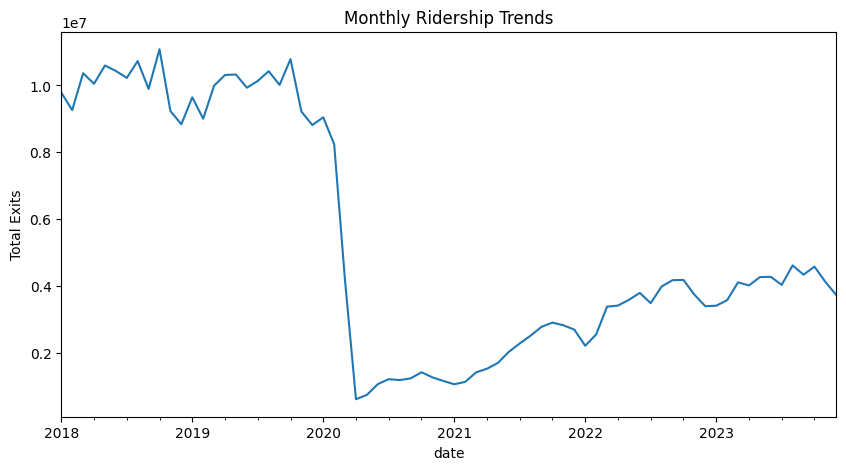

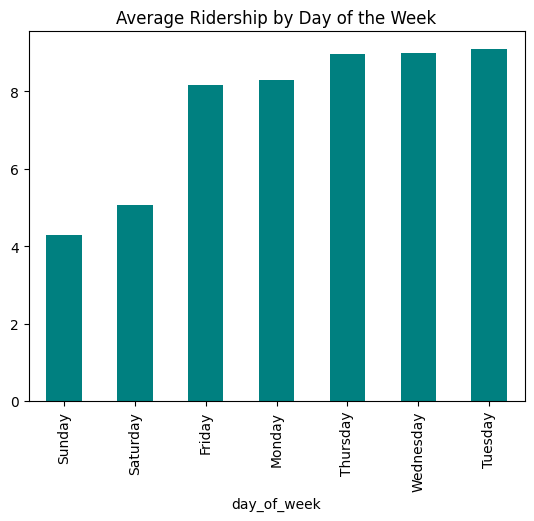

In [11]:
# Monthly ridership trends
monthly_ridership = data.groupby(data['date'].dt.to_period('M'))['Number of Exits'].sum()
monthly_ridership.plot(kind='line', figsize=(10, 5), title='Monthly Ridership Trends')
plt.ylabel('Total Exits')
plt.show()

# Day-wise ridership trends (average per weekday)
daywise_ridership = data.groupby('day_of_week')['Number of Exits'].mean().sort_values()
daywise_ridership.plot(kind='bar', title='Average Ridership by Day of the Week', color='teal')
plt.show()

In [12]:
# Top 10 busiest days
busiest_days = data.groupby('date')['Number of Exits'].sum().nlargest(10)
print(busiest_days)

date
2018-06-12    498022
2019-10-02    474741
2019-11-07    460520
2018-09-27    454990
2018-11-08    454461
2018-09-26    454198
2018-09-20    453117
2018-09-12    452151
2018-10-24    449225
2018-04-17    448199
Name: Number of Exits, dtype: int64


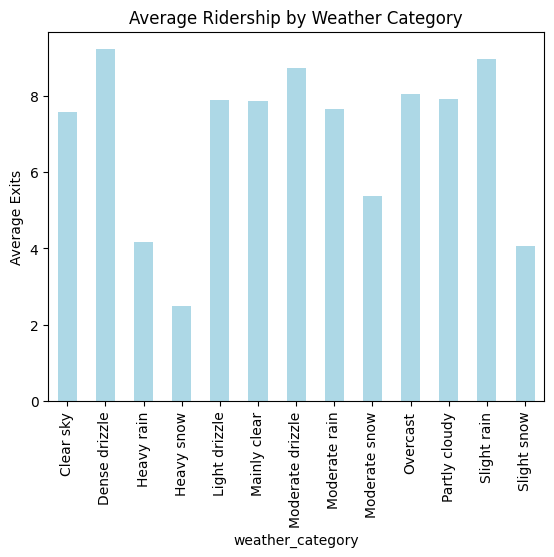

In [13]:
weather_ridership = data.groupby('weather_category')['Number of Exits'].mean()
weather_ridership.plot(kind='bar', color='lightblue', title='Average Ridership by Weather Category')
plt.ylabel('Average Exits')
plt.show()

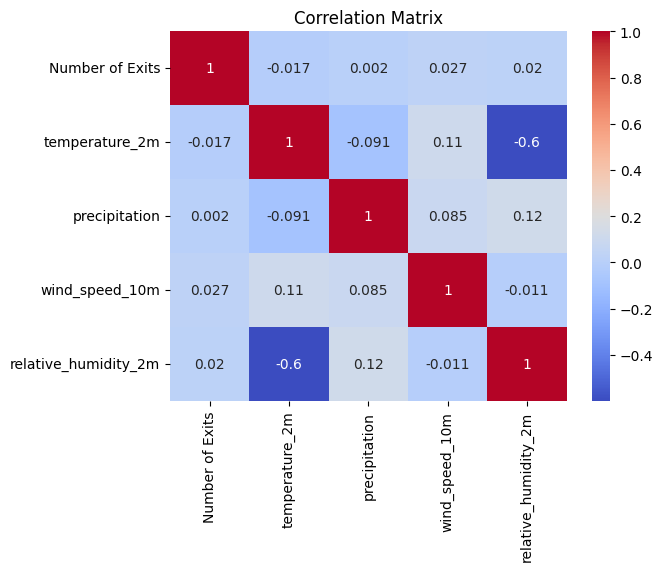

In [14]:
correlation = data[['Number of Exits', 'temperature_2m', 'precipitation',
                    'wind_speed_10m', 'relative_humidity_2m']].corr()

# Plot a heatmap
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

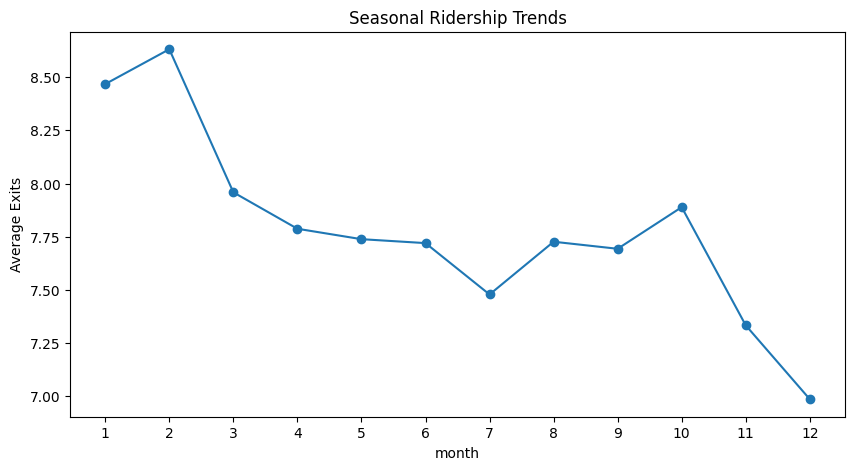

In [15]:
data['month'] = data['date'].dt.month
seasonal_ridership = data.groupby('month')['Number of Exits'].mean()

seasonal_ridership.plot(kind='line', marker='o', title='Seasonal Ridership Trends', figsize=(10, 5))
plt.ylabel('Average Exits')
plt.xticks(range(1, 13))
plt.show()

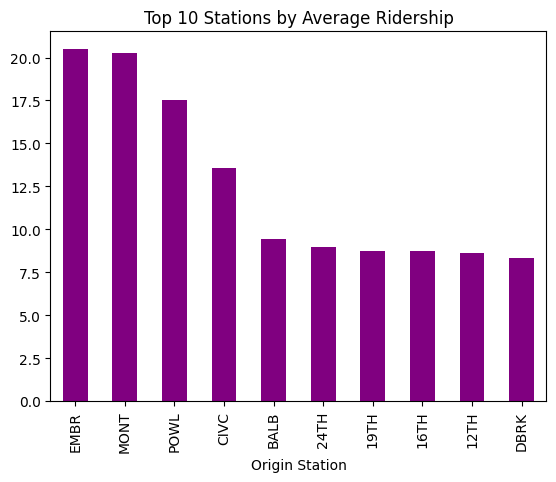

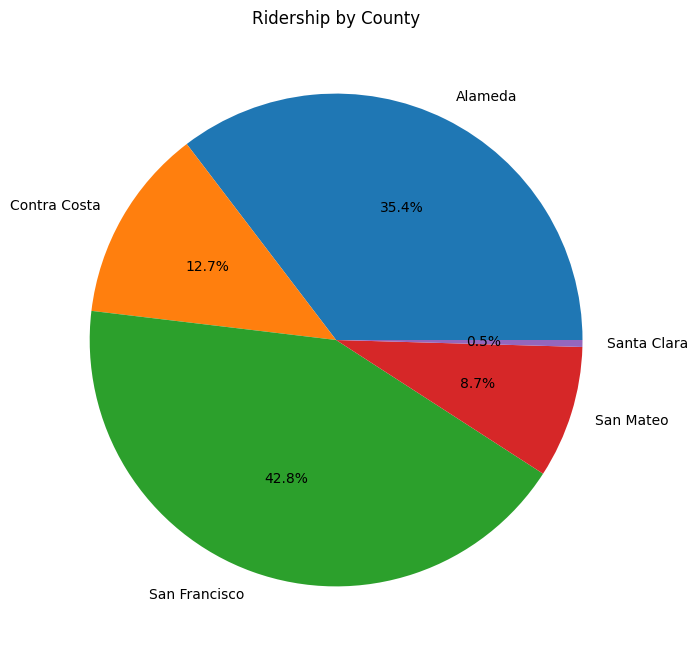

In [16]:
station_ridership = data.groupby('Origin Station')['Number of Exits'].mean().nlargest(10)
station_ridership.plot(kind='bar', title='Top 10 Stations by Average Ridership', color='purple')
plt.show()

county_ridership = data.groupby('county')['Number of Exits'].sum()
county_ridership.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8), title='Ridership by County')
plt.ylabel('')
plt.show()

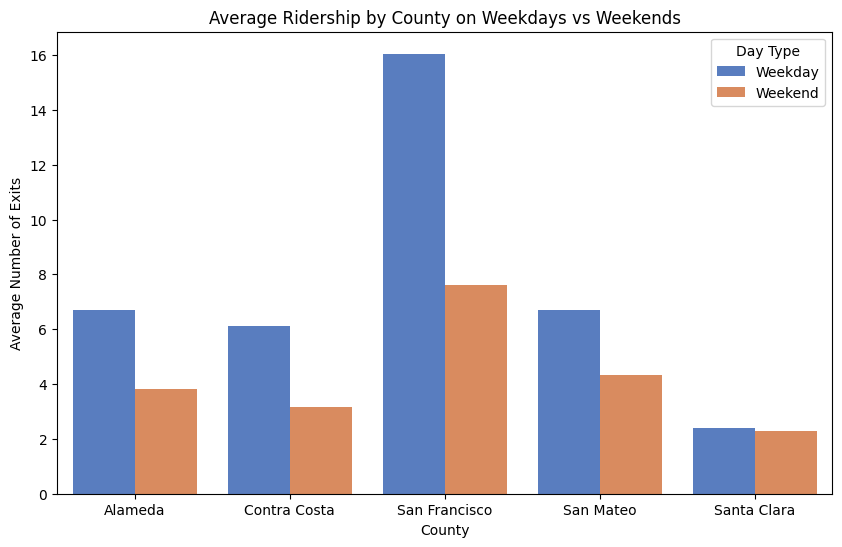

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new column to identify weekdays and weekends
data['day_type'] = data['date'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Group by county and day_type to get the average ridership
county_ridership = data.groupby(['county', 'day_type'])['Number of Exits'].mean().reset_index()

# Plotting the visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=county_ridership, x='county', y='Number of Exits', hue='day_type', palette='muted')
plt.title('Average Ridership by County on Weekdays vs Weekends')
plt.ylabel('Average Number of Exits')
plt.xlabel('County')
plt.legend(title='Day Type')
plt.show()


In [18]:
# Extract Day of Week and Weekend Indicator
data['day_of_week'] = pd.to_datetime(data['date']).dt.day_name()
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

# Create Lag Feature (1 day lag for example)
data['ridership_lag_1'] = data['Number of Exits'].shift(24)  # 24-hour lag

# Create 7-day Moving Average of Ridership
data['ridership_7d_avg'] = data['Number of Exits'].rolling(window=7).mean()

# Handle any NaN values generated from shift or rolling operations
data.fillna(0, inplace=True)

# Display the first few rows to verify
print(data.head())


        date  hour Origin Station Destination Station  Number of Exits  Year  \
0 2018-01-01     0           12TH                12TH                3  2018   
1 2018-01-01     0           12TH                16TH                1  2018   
2 2018-01-01     0           12TH                BAYF                1  2018   
3 2018-01-01     0           12TH                CAST                3  2018   
4 2018-01-01     0           12TH                CIVC                2  2018   

    county  temperature_2m  precipitation  weather_code  ...  \
0  Alameda             9.0            0.0             1  ...   
1  Alameda             9.0            0.0             1  ...   
2  Alameda             9.0            0.0             1  ...   
3  Alameda             9.0            0.0             1  ...   
4  Alameda             9.0            0.0             1  ...   

   relative_humidity_2m  weather_category    holiday_name is_holiday  \
0                    95      Mainly clear  New Year's Day     

In [19]:
data.columns

Index(['date', 'hour', 'Origin Station', 'Destination Station',
       'Number of Exits', 'Year', 'county', 'temperature_2m', 'precipitation',
       'weather_code', 'wind_speed_10m', 'wind_direction_10m',
       'relative_humidity_2m', 'weather_category', 'holiday_name',
       'is_holiday', 'day_of_week', 'month', 'day_type', 'is_weekend',
       'ridership_lag_1', 'ridership_7d_avg'],
      dtype='object')

In [20]:
data['ridership_7d_avg'].max()

410.57142857142856

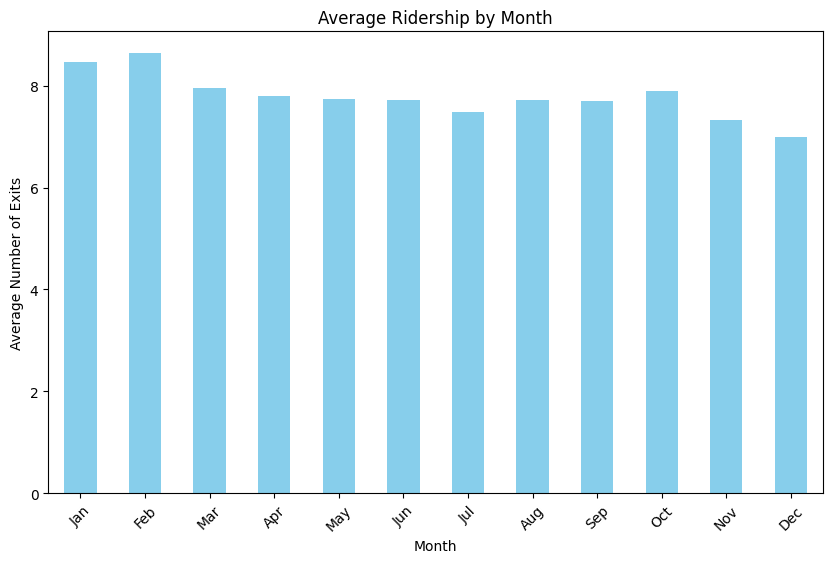

In [21]:
# Calculate average ridership by month
monthly_avg_ridership = data.groupby('month')['Number of Exits'].mean()

# Plot
plt.figure(figsize=(10, 6))
monthly_avg_ridership.plot(kind='bar', color='skyblue')
plt.title('Average Ridership by Month')
plt.xlabel('Month')
plt.ylabel('Average Number of Exits')
plt.xticks(ticks=range(12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
], rotation=45)
plt.show()

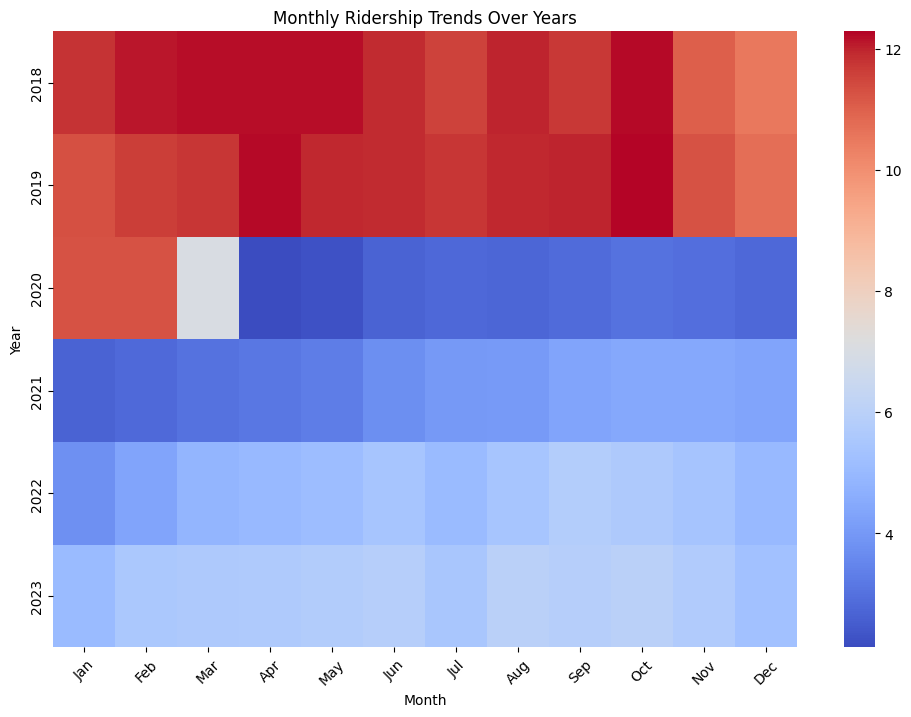

In [22]:
# Add year column for better visualization
data['year'] = data['date'].dt.year

# Monthly ridership trends
monthly_trends = data.groupby(['year', 'month'])['Number of Exits'].mean().unstack()

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(monthly_trends, cmap='coolwarm', annot=False, cbar=True)
plt.title('Monthly Ridership Trends Over Years')
plt.xlabel('Month')
plt.ylabel('Year')
plt.xticks(ticks=np.arange(12) + 0.5, labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
], rotation=45)
plt.show()

In [23]:
# Create the 'weekend_service' column based on the given rules
data['weekend_service'] = ((data['is_holiday'] == 1) | (data['is_weekend'] == 1)).astype(int)

# Verify the changes
print(data[['date', 'is_holiday', 'is_weekend', 'weekend_service']].head(15))

         date  is_holiday  is_weekend  weekend_service
0  2018-01-01           1           0                1
1  2018-01-01           1           0                1
2  2018-01-01           1           0                1
3  2018-01-01           1           0                1
4  2018-01-01           1           0                1
5  2018-01-01           1           0                1
6  2018-01-01           1           0                1
7  2018-01-01           1           0                1
8  2018-01-01           1           0                1
9  2018-01-01           1           0                1
10 2018-01-01           1           0                1
11 2018-01-01           1           0                1
12 2018-01-01           1           0                1
13 2018-01-01           1           0                1
14 2018-01-01           1           0                1


In [24]:
# Encode Categorical Variables
encoder = LabelEncoder()

data['Origin Station'] = encoder.fit_transform(data['Origin Station'])
data['Destination Station'] = encoder.fit_transform(data['Destination Station'])
data['weather_category'] = encoder.fit_transform(data['weather_category'])
data['day_of_week'] = encoder.fit_transform(data['day_of_week'])
data['county'] = encoder.fit_transform(data['county'])

In [25]:
# Splitting the data into pre-COVID and post-COVID
pre_covid_data = data[data['date'] < '2020-03-01']
post_covid_data = data[data['date'] >= '2020-03-01']

In [ ]:
def preprocess_data(df):
    features = ['hour', 'Origin Station', 'Destination Station', 'temperature_2m', 'precipitation',
                'wind_speed_10m', 'relative_humidity_2m', 'is_holiday', 'is_weekend']
    X = df[features].values
    y = df['Number of Exits'].values

    # Scaling the data
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    y_scaled = scaler.fit_transform(y.reshape(-1, 1))

    # Reshape for LSTM
    X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled,
                                                        test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test, scaler

In [ ]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(32))
    model.add(Dense(1))  # Output layer

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def train_and_evaluate(X_train, X_test, y_train, y_test):
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), verbose=1)

    # Evaluate model
    test_loss = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss}')
    return model

# LSTM Model

In [ ]:
# Post-COVID LSTM Model
X_train_post, X_test_post, y_train_post, y_test_post, scaler_post = preprocess_data(post_covid_data)
print("Training Post-COVID Model...")
model_post = train_and_evaluate(X_train_post, X_test_post, y_train_post, y_test_post)

Training Post-COVID Model...
Epoch 1/5
347644/347644 ━━━━━━━━━━━━━━━━━━━━ 404s 1ms/step - loss: 7.9003e-05 - val_loss: 7.6368e-05
Epoch 2/5
347644/347644 ━━━━━━━━━━━━━━━━━━━━ 424s 1ms/step - loss: 7.6770e-05 - val_loss: 7.5799e-05
Epoch 3/5
347644/347644 ━━━━━━━━━━━━━━━━━━━━ 466s 1ms/step - loss: 7.5937e-05 - val_loss: 7.5336e-05
Epoch 4/5
347644/347644 ━━━━━━━━━━━━━━━━━━━━ 448s 1ms/step - loss: 7.5444e-05 - val_loss: 7.1907e-05
Epoch 5/5
347644/347644 ━━━━━━━━━━━━━━━━━━━━ 487s 1ms/step - loss: 7.1622e-05 - val_loss: 6.9637e-05
173822/173822 ━━━━━━━━━━━━━━━━━━━━ 112s 642us/step - loss: 6.9331e-05
Test Loss: 6.963723717490211e-05


In [ ]:
# Pre-COVID LSTM Model
X_train_pre, X_test_pre, y_train_pre, y_test_pre, scaler_pre = preprocess_data(pre_covid_data)
print("Training Pre-COVID Model...")
model_pre = train_and_evaluate(X_train_pre, X_test_pre, y_train_pre, y_test_pre)

Training Pre-COVID Model...
Epoch 1/5
273452/273452 ━━━━━━━━━━━━━━━━━━━━ 365s 1ms/step - loss: 7.2678e-04 - val_loss: 6.8331e-04
Epoch 2/5
273452/273452 ━━━━━━━━━━━━━━━━━━━━ 375s 1ms/step - loss: 6.4262e-04 - val_loss: 5.1171e-04
Epoch 3/5
273452/273452 ━━━━━━━━━━━━━━━━━━━━ 360s 1ms/step - loss: 4.9883e-04 - val_loss: 4.2088e-04
Epoch 4/5
273452/273452 ━━━━━━━━━━━━━━━━━━━━ 374s 1ms/step - loss: 4.0746e-04 - val_loss: 3.4820e-04
Epoch 5/5
273452/273452 ━━━━━━━━━━━━━━━━━━━━ 378s 1ms/step - loss: 3.3185e-04 - val_loss: 2.9512e-04
136726/136726 ━━━━━━━━━━━━━━━━━━━━ 83s 604us/step - loss: 2.9440e-04
Test Loss: 0.00029512582113966346


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Function to calculate metrics
def calculate_metrics(y_test, y_pred):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}%")

# Make predictions on the test data (Post-COVID)
y_pred_post = model_post.predict(X_test_post)
y_pred_post = scaler_post.inverse_transform(y_pred_post)
y_test_post = scaler_post.inverse_transform(y_test_post)

print("Post-COVID Model Metrics:")
calculate_metrics(y_test_post, y_pred_post)

173822/173822 ━━━━━━━━━━━━━━━━━━━━ 99s 571us/step
Post-COVID Model Metrics:
RMSE: 8.586821072795951
MAE: 3.8715060723845625
MAPE: 142.12388665619287%


In [ ]:
# Make predictions on the test data (Pre-COVID)
y_pred_pre = model_pre.predict(X_test_pre)
y_pred_pre = scaler_pre.inverse_transform(y_pred_pre)
y_test_pre = scaler_pre.inverse_transform(y_test_pre)

print("\nPre-COVID Model Metrics:")
calculate_metrics(y_test_pre, y_pred_pre)

136726/136726 ━━━━━━━━━━━━━━━━━━━━ 79s 575us/step

Pre-COVID Model Metrics:
RMSE: 19.996600594923546
MAE: 8.715058270062922
MAPE: 220.4372014452165%


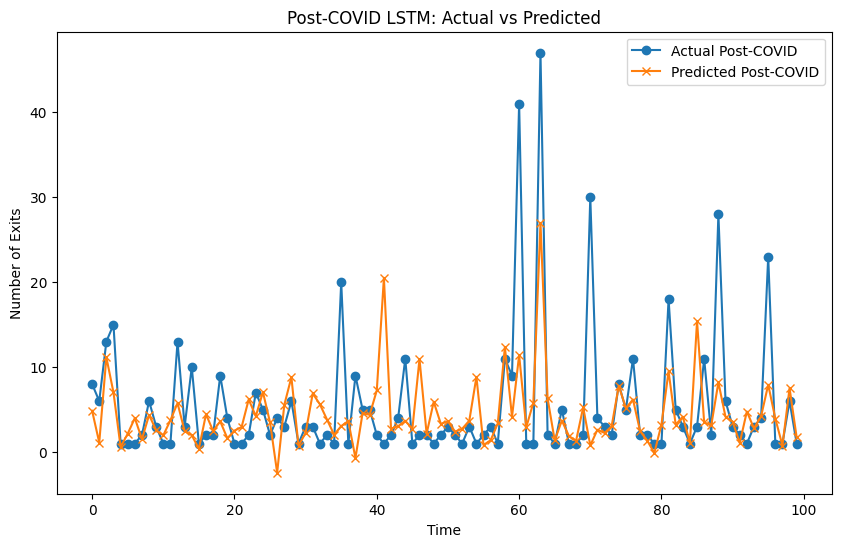

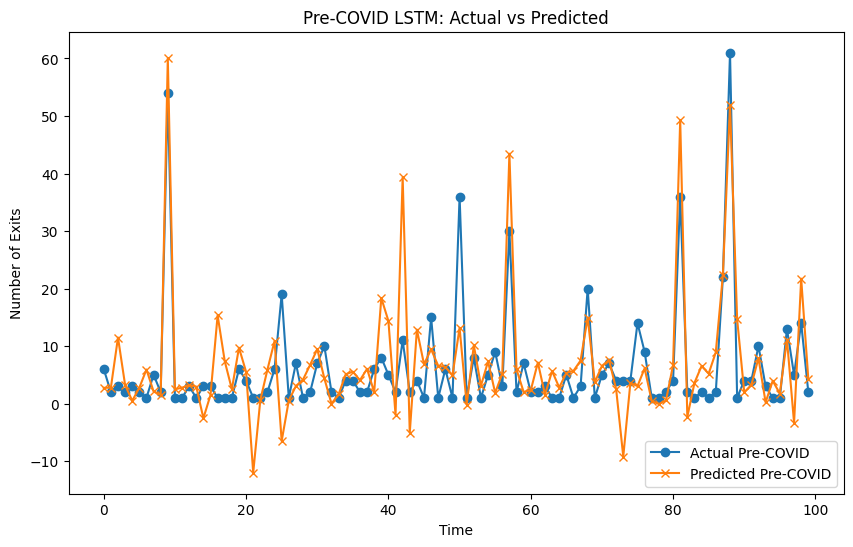

In [ ]:
# Plotting Actual vs Predicted for Post-COVID Model
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_post[:100], label='Actual Post-COVID', marker='o')
plt.plot(y_pred_post[:100], label='Predicted Post-COVID', marker='x')
plt.title('Post-COVID LSTM: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Number of Exits')
plt.legend()
plt.show()

# Plotting Actual vs Predicted for Pre-COVID Model
plt.figure(figsize=(10, 6))
plt.plot(y_test_pre[:100], label='Actual Pre-COVID', marker='o')
plt.plot(y_pred_pre[:100], label='Predicted Pre-COVID', marker='x')
plt.title('Pre-COVID LSTM: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Number of Exits')
plt.legend()
plt.show()


In [ ]:
# Save the trained LSTM model
model_pre.save('lstm_model_pre_covid.h5')
model_post.save('lstm_model_post_covid.h5')

# TCN Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling1D
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [ ]:
X_train, X_test, y_train, y_test, scaler = preprocess_data(data)

In [ ]:
# Step 2: Build the TCN Model
def build_tcn_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),

        Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        Dropout(0.3),

        Flatten(),
        Dense(50, activation='relu'),
        Dropout(0.2),
        Dense(1)  # Output layer for regression
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
# Step 3: Initialize and Train the Model
input_shape = (X_train.shape[1], X_train.shape[2])
tcn_model = build_tcn_model(input_shape)

W0000 00:00:1731966197.800057      25 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
# Train the model
history = tcn_model.fit(
    X_train, y_train,
    epochs=5,  # Start with fewer epochs, adjust later if needed
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/5
621095/621095 ━━━━━━━━━━━━━━━━━━━━ 2334s 4ms/step - loss: 0.0018 - val_loss: 3.6905e-04
Epoch 2/5
621095/621095 ━━━━━━━━━━━━━━━━━━━━ 2109s 3ms/step - loss: 3.7154e-04 - val_loss: 3.6197e-04
Epoch 3/5
621095/621095 ━━━━━━━━━━━━━━━━━━━━ 1958s 3ms/step - loss: 3.6990e-04 - val_loss: 3.5359e-04
Epoch 4/5
621095/621095 ━━━━━━━━━━━━━━━━━━━━ 1961s 3ms/step - loss: 3.6794e-04 - val_loss: 3.6066e-04
Epoch 5/5
621095/621095 ━━━━━━━━━━━━━━━━━━━━ 1963s 3ms/step - loss: 3.6894e-04 - val_loss: 3.6518e-04


In [ ]:
# Step 4: Evaluate the Model
test_loss = tcn_model.evaluate(X_test, y_test, verbose=0)
y_pred = tcn_model.predict(X_test)

310548/310548 ━━━━━━━━━━━━━━━━━━━━ 415s 1ms/step


In [ ]:
# Rescale predictions back to original scale
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

In [ ]:
# Calculate Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"Test Loss: {test_loss}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")

Test Loss: 0.0003651810111477971
RMSE: 22.24381404733655
MAE: 8.577728092463175
MAPE: 321.32751609796236%


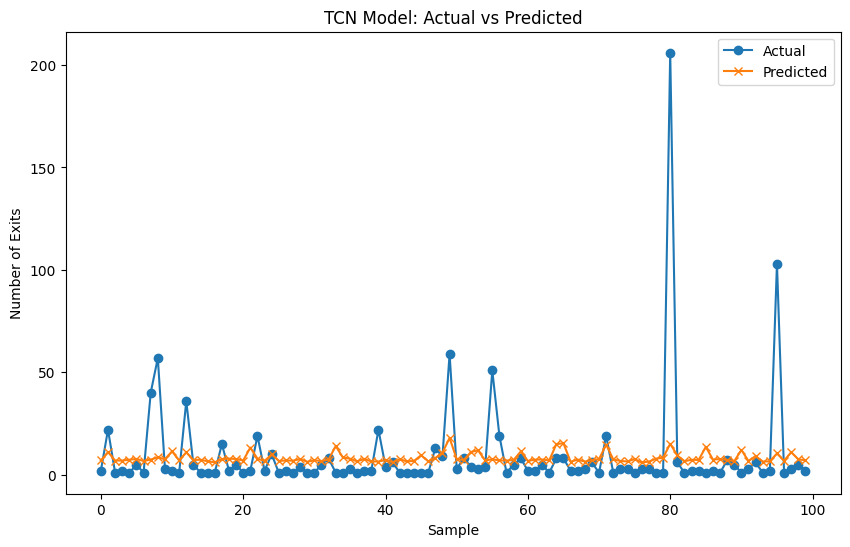

In [ ]:
# Step 5: Plot Predictions vs Actual Values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test[:100], label='Actual', marker='o')
plt.plot(y_pred[:100], label='Predicted', marker='x')
plt.title('TCN Model: Actual vs Predicted')
plt.xlabel('Sample')
plt.ylabel('Number of Exits')
plt.legend()
plt.show()

# TCN with Darts

In [ ]:
data.columns

Index(['hour', 'Origin Station', 'Destination Station', 'Number of Exits',
       'Year', 'county', 'temperature_2m', 'precipitation', 'weather_code',
       'wind_speed_10m', 'wind_direction_10m', 'relative_humidity_2m',
       'weather_category', 'holiday_name', 'is_holiday', 'day_of_week',
       'month', 'day_type', 'is_weekend', 'ridership_lag_1',
       'ridership_7d_avg'],
      dtype='object')

<ipython-input-1-09324817e112>:9: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/MyDrive/DATA-255/DL_Project/Datasets/Combined Datasets/ridership_and_weather_data_combined_2018_to_2023.csv')
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 4.9 K 
----------------

Training the TCN model...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

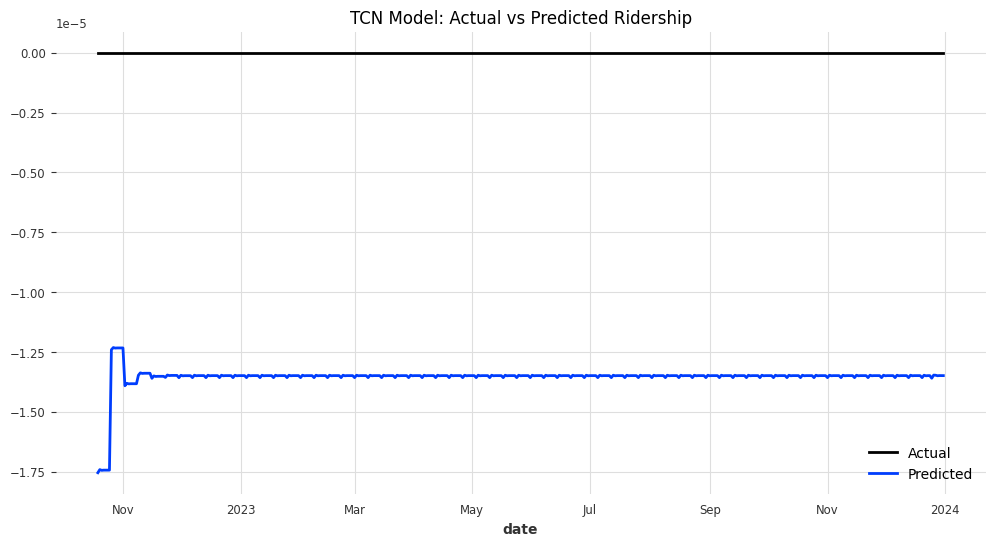

RMSE: 1.3557818783638008e-05
MAE: 1.3547825604653901e-05
MAPE: inf%


<ipython-input-1-09324817e112>:64: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((test_actual.values() - predictions.values()) / test_actual.values())) * 100


In [ ]:
from darts import TimeSeries
from darts.models import TCNModel
from darts.dataprocessing.transformers import Scaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('/content/drive/MyDrive/DATA-255/DL_Project/Datasets/Combined Datasets/ridership_and_weather_data_combined_2018_to_2023.csv')

# Convert 'date' column to datetime and ensure it is the index
data.set_index('date', inplace=True)

# Aggregate ridership data daily and ensure a consistent frequency
data = data[['Number of Exits']].groupby('date').sum().asfreq('D')

# Fill missing values in ridership with 0
data['Number of Exits'] = data['Number of Exits'].fillna(0)

# Convert the DataFrame into a Darts TimeSeries object
series = TimeSeries.from_dataframe(data, value_cols='Number of Exits')

# Scale the data
scaler = Scaler()
series_scaled = scaler.fit_transform(series)

# Split the data into training and testing sets (80-20 split)
train, test = series_scaled.split_before(0.8)

# Define and train the TCN model
tcn_model = TCNModel(
    input_chunk_length=30,  # Number of past days the model looks at
    output_chunk_length=7,  # Number of future days the model predicts
    kernel_size=3,  # Convolutional kernel size
    num_filters=16,  # Number of convolutional filters
    dropout=0.1,  # Dropout rate to prevent overfitting
    random_state=42,  # For reproducibility
    n_epochs=50,  # Number of epochs
    batch_size=32,  # Batch size
    optimizer_kwargs={"lr": 1e-3}  # Learning rate for optimizer
)

print("Training the TCN model...")
tcn_model.fit(train)

# Forecast on the test set
predictions = tcn_model.predict(len(test))

# Inverse transform predictions and actual values
predictions = scaler.inverse_transform(predictions)
test_actual = scaler.inverse_transform(test)

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
test_actual.plot(label='Actual', lw=2)
predictions.plot(label='Predicted', lw=2)
plt.title('TCN Model: Actual vs Predicted Ridership')
plt.legend()
plt.show()

# Evaluate the model
rmse = np.sqrt(mean_squared_error(test_actual.values(), predictions.values()))
mae = mean_absolute_error(test_actual.values(), predictions.values())
mape = np.mean(np.abs((test_actual.values() - predictions.values()) / test_actual.values())) * 100

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")

In [ ]:
pip install scikit-learn==1.0.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 25.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2


# Updated TCN code

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Define the pre-processing function
def preprocess_data_tcn(df):
    # Features to include
    features = [
        'hour', 'Origin Station', 'Destination Station', 'temperature_2m',
        'precipitation', 'wind_speed_10m', 'relative_humidity_2m',
        'is_holiday', 'is_weekend', 'ridership_lag_1', 'ridership_7d_avg'
    ]

    # Select features and target variable
    X = df[features].values
    y = df['Number of Exits'].values

    # Scale the data
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

    # Split the data sequentially (time-series split)
    split_index = int(len(X_scaled) * 0.8)
    X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
    y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]

    return X_train, X_test, y_train, y_test, scaler_X, scaler_y

# Apply the updated pre-processing
X_train, X_test, y_train, y_test, scaler_X, scaler_y = preprocess_data_tcn(data)

In [ ]:
# Check the shape of X_train and X_test before reshaping
print(f"Original X_train shape: {X_train.shape}")
print(f"Original X_test shape: {X_test.shape}")

# Ensure X_train and X_test are 3D for Conv1D
if len(X_train.shape) == 2:
    # Reshape for Conv1D: (samples, timesteps, features)
    X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    print(f"Reshaped X_train shape: {X_train_reshaped.shape}")
    print(f"Reshaped X_test shape: {X_test_reshaped.shape}")
else:
    print("Data already has timesteps dimension. No reshaping required.")
    X_train_reshaped = X_train
    X_test_reshaped = X_test

# Validate that reshaped data has no zero dimensions
assert X_train_reshaped.shape[1] > 0, "Timesteps dimension cannot be zero"
assert X_train_reshaped.shape[2] > 0, "Features dimension cannot be zero"

Original X_train shape: (39750064, 11)
Original X_test shape: (9937516, 11)
Reshaped X_train shape: (39750064, 1, 11)
Reshaped X_test shape: (9937516, 1, 11)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, BatchNormalization

def build_tcn_model(input_shape):
    model = Sequential([
        Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        Dropout(0.2),
        Conv1D(filters=32, kernel_size=2, activation='relu', padding='same'),
        BatchNormalization(),
        Dropout(0.2),
        Flatten(),
        Dense(50, activation='relu'),
        Dropout(0.2),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
# Build the TCN model
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])
tcn_model = build_tcn_model(input_shape)

# Train the model
print("Training the TCN model...")
history = tcn_model.fit(
    X_train_reshaped, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test_reshaped, y_test),
    verbose=1
)

# Evaluate the model
test_loss = tcn_model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"Test Loss: {test_loss}")

Training the TCN model...
Epoch 1/10
621095/621095 ━━━━━━━━━━━━━━━━━━━━ 1139s 2ms/step - loss: 0.0013 - val_loss: 5.9026e-05
Epoch 2/10
621095/621095 ━━━━━━━━━━━━━━━━━━━━ 1129s 2ms/step - loss: 2.8263e-04 - val_loss: 6.4921e-05
Epoch 3/10
621095/621095 ━━━━━━━━━━━━━━━━━━━━ 1128s 2ms/step - loss: 2.8203e-04 - val_loss: 6.0891e-05
Epoch 4/10
621095/621095 ━━━━━━━━━━━━━━━━━━━━ 1122s 2ms/step - loss: 2.8287e-04 - val_loss: 5.9488e-05
Epoch 5/10
621095/621095 ━━━━━━━━━━━━━━━━━━━━ 1118s 2ms/step - loss: 2.8315e-04 - val_loss: 5.8500e-05
Epoch 6/10
621095/621095 ━━━━━━━━━━━━━━━━━━━━ 1114s 2ms/step - loss: 2.8257e-04 - val_loss: 5.9011e-05
Epoch 7/10
621095/621095 ━━━━━━━━━━━━━━━━━━━━ 1108s 2ms/step - loss: 2.7958e-04 - val_loss: 5.4427e-05
Epoch 8/10
621095/621095 ━━━━━━━━━━━━━━━━━━━━ 1109s 2ms/step - loss: 2.6001e-04 - val_loss: 6.0817e-05
Epoch 9/10
621095/621095 ━━━━━━━━━━━━━━━━━━━━ 1112s 2ms/step - loss: 2.4766e-04 - val_loss: 6.0206e-05
Epoch 10/10
621095/621095 ━━━━━━━━━━━━━━━━━━━━ 1114

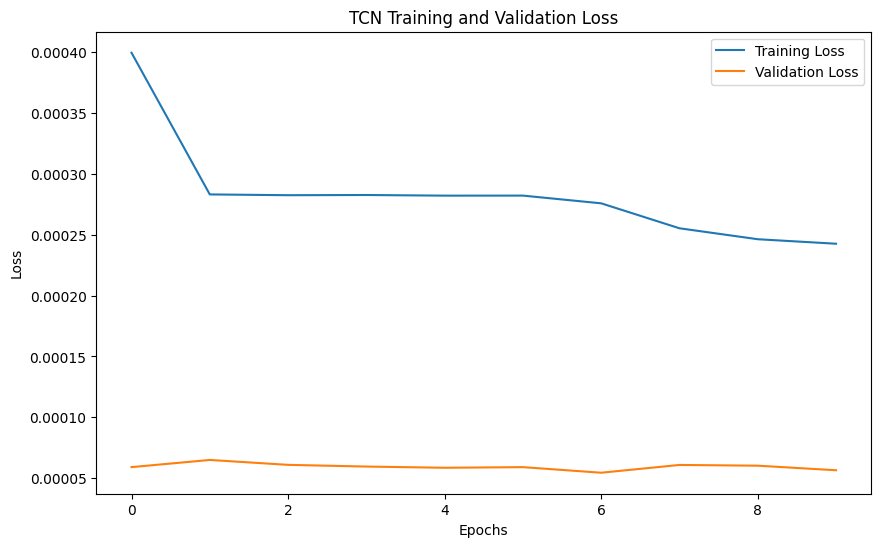

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('TCN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Make predictions on the test data
print("Predicting on test data...")
y_pred = tcn_model.predict(X_test_reshaped)

Predicting on test data...
310548/310548 ━━━━━━━━━━━━━━━━━━━━ 346s 1ms/step


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Inverse transform the scaled values
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))

# Calculate MAE
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

# Calculate MAPE
mape = np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / y_test_rescaled)) * 100

# Print the metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")

RMSE: 8.746509874425483
MAE: 4.4189623235515
MAPE: 166.84%


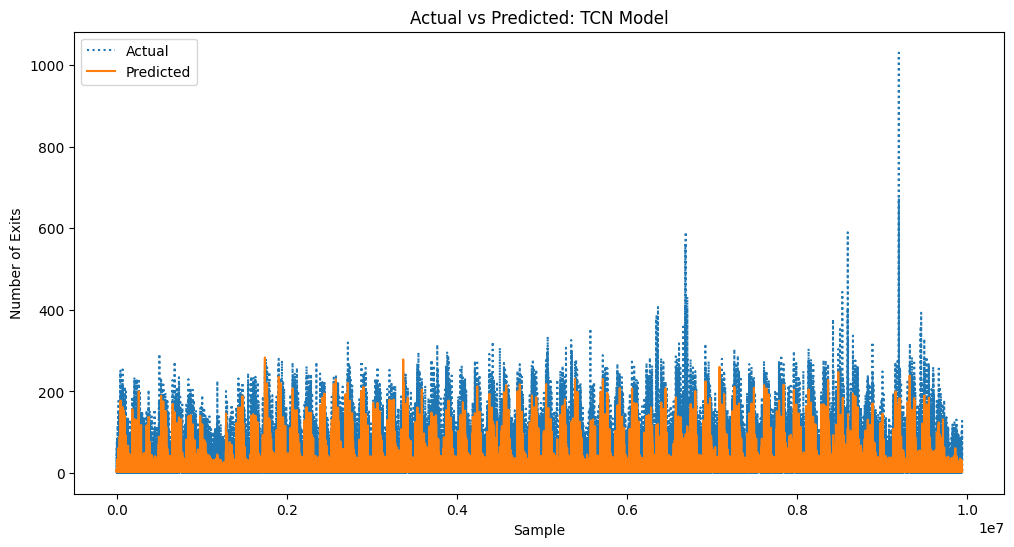

In [ ]:
# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual", linestyle='dotted')
plt.plot(y_pred_rescaled, label="Predicted")
plt.title("Actual vs Predicted: TCN Model")
plt.xlabel("Sample")
plt.ylabel("Number of Exits")
plt.legend()
plt.show()

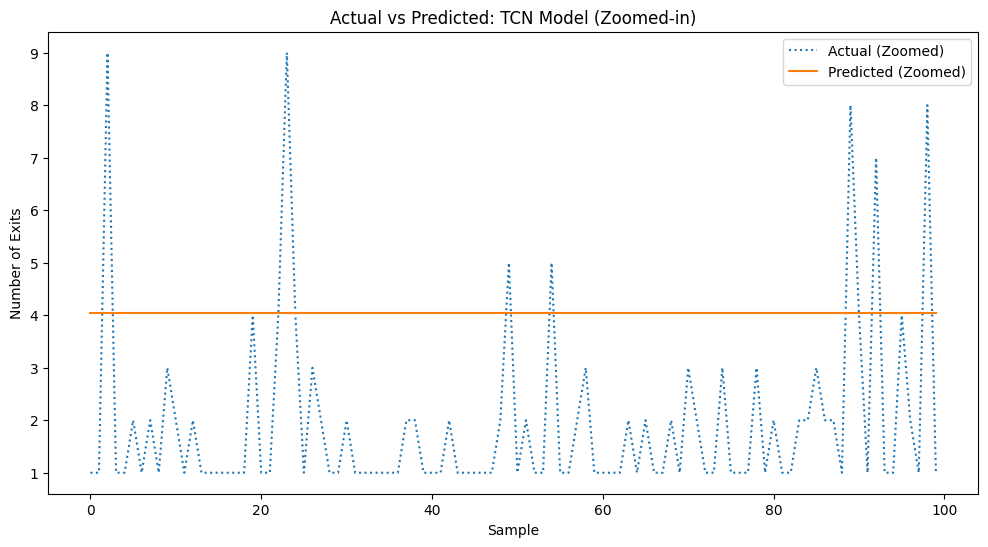

In [ ]:
# Plot a zoomed-in view of Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled[:100], label="Actual (Zoomed)", linestyle='dotted')
plt.plot(y_pred_rescaled[:100], label="Predicted (Zoomed)")
plt.title("Actual vs Predicted: TCN Model (Zoomed-in)")
plt.xlabel("Sample")
plt.ylabel("Number of Exits")
plt.legend()
plt.show()

In [ ]:
# Save the trained model as a .h5 file
model_path = "tcn_model.h5"
tcn_model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to tcn_model.h5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# TCN with updated features

In [26]:
# Updated preprocessing function
def preprocess_data_tcn(df):
    # Selected features based on analysis
    features = [
        'hour', 'Origin Station', 'Destination Station', 'temperature_2m',
        'precipitation', 'wind_speed_10m', 'relative_humidity_2m',
        'weekend_service', 'ridership_lag_1', 'ridership_7d_avg'
    ]
    target = 'Number of Exits'

    # Select features and target variable
    X = df[features].values
    y = df[target].values

    # Scale the features and target
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

    # Split into training and testing sets (time-series split)
    split_index = int(len(X_scaled) * 0.8)
    X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
    y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]

    # Reshape features for Conv1D (samples, timesteps, features)
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    return X_train, X_test, y_train, y_test, scaler_X, scaler_y

# Apply preprocessing
X_train, X_test, y_train, y_test, scaler_X, scaler_y = preprocess_data_tcn(data)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam

# Build TCN model
def build_tcn_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        Dropout(0.2),
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        Dropout(0.2),
        Flatten(),
        Dense(50, activation='relu'),
        Dropout(0.2),
        Dense(1)  # Output layer for regression
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Get input shape for Conv1D
input_shape = (X_train.shape[1], X_train.shape[2])

# Build the TCN model
tcn_model = build_tcn_model(input_shape)

# Train the TCN model
print("Training the TCN model...")
history = tcn_model.fit(
    X_train, y_train,
    epochs=2,  # Adjust based on needs
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)

Training the TCN model...
Epoch 1/2
621095/621095 ━━━━━━━━━━━━━━━━━━━━ 1154s 2ms/step - loss: 0.0013 - val_loss: 6.3569e-05
Epoch 2/2
621095/621095 ━━━━━━━━━━━━━━━━━━━━ 1165s 2ms/step - loss: 2.7185e-04 - val_loss: 5.3824e-05


In [ ]:
# Predict on test data
y_pred = tcn_model.predict(X_test)

# Rescale predictions and actuals back to original scale
y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

310548/310548 ━━━━━━━━━━━━━━━━━━━━ 362s 1ms/step


NameError: name 'mean_squared_error' is not defined

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mape = np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / y_test_rescaled)) * 100

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")

RMSE: 8.539613601707957
MAE: 4.212549811278136
MAPE: 154.20%


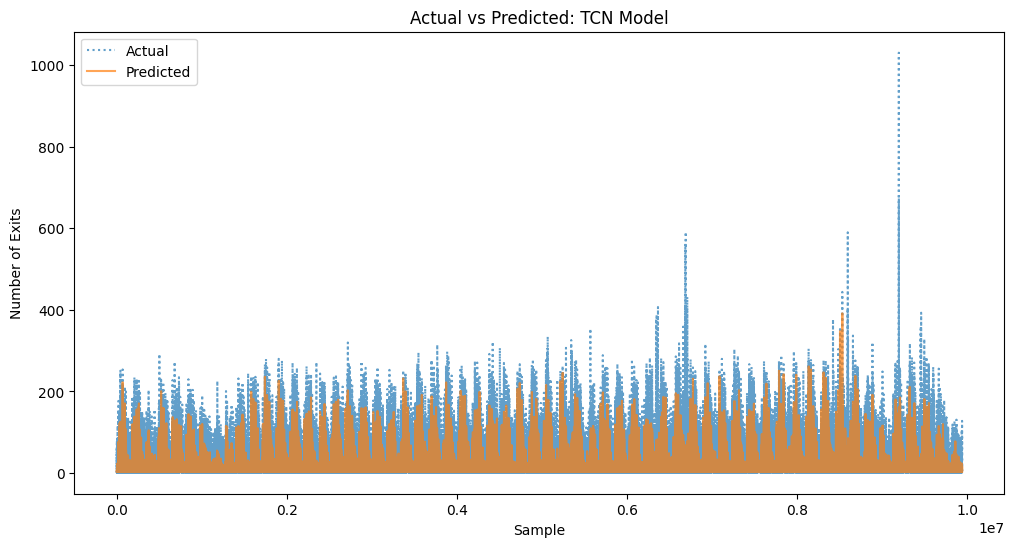

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual', linestyle='dotted', alpha=0.7)
plt.plot(y_pred_rescaled, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted: TCN Model')
plt.xlabel('Sample')
plt.ylabel('Number of Exits')
plt.legend()
plt.show()

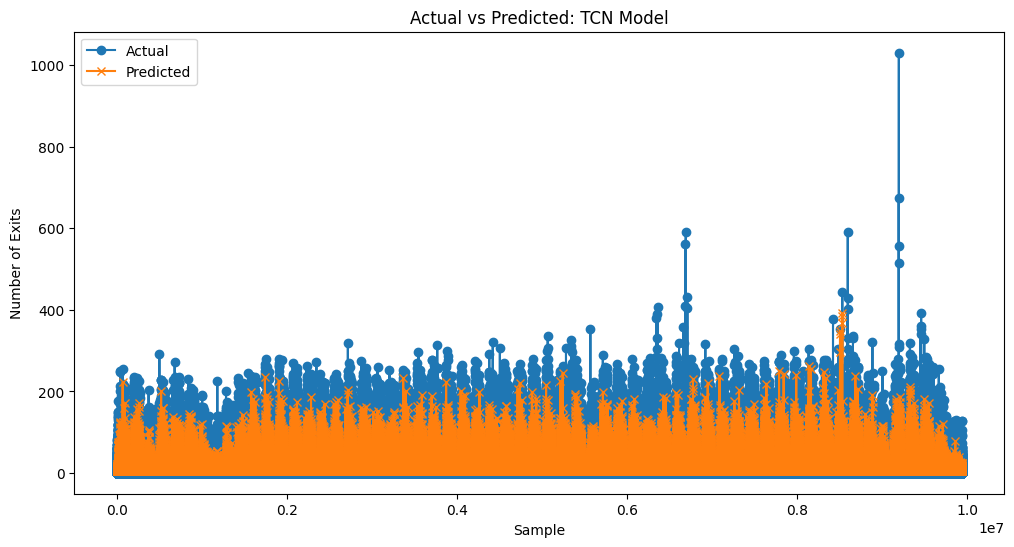

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual', marker='o')
plt.plot(y_pred_rescaled, label='Predicted', marker='x')
plt.title('Actual vs Predicted: TCN Model')
plt.xlabel('Sample')
plt.ylabel('Number of Exits')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Generate predictions for the test set
y_pred = tcn_model.predict(X_test).flatten()

# Plot Actual vs Predicted with no fill color
plt.figure(figsize=(10, 6))
plt.plot(y_test[:100], label='Actual', marker='o', linestyle='-', linewidth=1)
plt.plot(y_pred[:100], label='Predicted', marker='x', linestyle='-', linewidth=1)
plt.title('TCN Model: Actual vs Predicted', fontsize=14)
plt.xlabel('Sample', fontsize=12)
plt.ylabel('Number of Exits', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()

# Updated TCN with ensemble

In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, BatchNormalization, Add, Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

In [30]:
# Assuming your DataFrame is named `data`
selected_features = [
    'hour', 'Origin Station', 'Destination Station',
    'temperature_2m', 'precipitation', 'wind_speed_10m',
    'relative_humidity_2m', 'weekend_service',
    'ridership_lag_1', 'ridership_7d_avg'
]

X = data[selected_features]
y = data['Number of Exits']

In [31]:
# Scaling the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Reshape data for TCN input
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (39750064, 1, 10)
Testing Data Shape: (9937516, 1, 10)


In [33]:
def build_hyper_tcn(hp):
    model = Sequential([
        Conv1D(
            filters=hp.Choice('filters', values=[32, 64, 128]),
            kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
            dilation_rate=hp.Choice('dilation_rate', values=[1, 2, 4]),
            activation='relu',
            input_shape=(X_train.shape[1], X_train.shape[2]),
            padding='same'
        ),
        BatchNormalization(),
        Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)),
        Flatten(),
        Dense(units=hp.Int('units', min_value=32, max_value=128, step=32), activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=hp.Choice('lr', values=[1e-2, 1e-3, 1e-4])), loss='mean_squared_error')
    return model

# Initialize the tuner
tuner = kt.RandomSearch(
    hypermodel=build_hyper_tcn,
    objective='val_loss',
    max_trials=3,
    executions_per_trial=1,
    directory='tcn_tuning',
    project_name='bart_tcn'
)

# Hyperparameter tuning
tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64)

# Retrieve best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Filters: {best_hps.get('filters')}")
print(f"Best Kernel Size: {best_hps.get('kernel_size')}")
print(f"Best Dropout Rate: {best_hps.get('dropout')}")

Trial 3 Complete [01h 26m 00s]
val_loss: 0.000233157814363949

Best val_loss So Far: 0.00023232983949128538
Total elapsed time: 04h 16m 31s
Best Filters: 32
Best Kernel Size: 7
Best Dropout Rate: 0.1


In [36]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Add, Flatten, Dense, Dropout

def build_final_tcn_with_residual(input_shape):
    inputs = Input(shape=input_shape)

    # First Convolution with Residual Connection
    x = Conv1D(filters=32, kernel_size=7, dilation_rate=1, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    residual_1 = x  # Residual connection 1

    # Second Convolution with Residual Connection
    x = Conv1D(filters=32, kernel_size=7, dilation_rate=2, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, residual_1])  # Adding residual connection

    # Third Convolution
    x = Conv1D(filters=32, kernel_size=7, dilation_rate=4, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)  # Dropout for regularization

    # Output Layer
    x = Flatten()(x)
    outputs = Dense(1)(x)

    # Model Compilation
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build the model with the final input shape
input_shape = (X_train.shape[1], X_train.shape[2])
final_residual_model = build_final_tcn_with_residual(input_shape)

# Train the model
history = final_residual_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=64,
    verbose=1
)

# Evaluate the model
test_loss = final_residual_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")

Epoch 1/5
621095/621095 ━━━━━━━━━━━━━━━━━━━━ 1169s 2ms/step - loss: 0.0014 - val_loss: 2.7945e-04
Epoch 2/5
621095/621095 ━━━━━━━━━━━━━━━━━━━━ 1169s 2ms/step - loss: 2.0948e-04 - val_loss: 0.0340
Epoch 3/5
621095/621095 ━━━━━━━━━━━━━━━━━━━━ 1172s 2ms/step - loss: 1.9376e-04 - val_loss: 6.6189
Epoch 4/5
621095/621095 ━━━━━━━━━━━━━━━━━━━━ 1176s 2ms/step - loss: 1.8167e-04 - val_loss: 0.0984
Epoch 5/5
621095/621095 ━━━━━━━━━━━━━━━━━━━━ 1177s 2ms/step - loss: 1.7821e-04 - val_loss: 3.6029e-04
Test Loss: 0.00036028792965225875


310548/310548 ━━━━━━━━━━━━━━━━━━━━ 356s 1ms/step
RMSE: 22.09412452475059
MAE: 6.762305556145252
MAPE: 200.24%


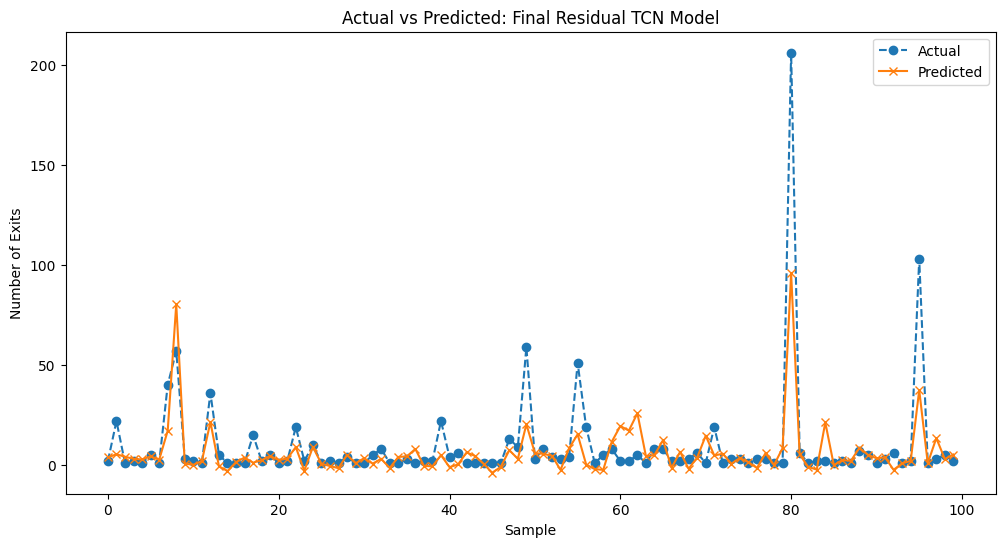

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Predictions
y_pred = final_residual_model.predict(X_test)

# Rescale predictions and true values
y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Calculate Metrics
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mape = np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / y_test_rescaled)) * 100

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")

# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled[:100], label='Actual', linestyle='--', marker='o')
plt.plot(y_pred_rescaled[:100], label='Predicted', linestyle='-', marker='x')
plt.title('Actual vs Predicted: Final Residual TCN Model')
plt.xlabel('Sample')
plt.ylabel('Number of Exits')
plt.legend()
plt.show()

In [38]:
residual_model.save('tcn_residual_model.h5')
print("Model saved as tcn_residual_model.h5")

Model saved as tcn_residual_model.h5


In [39]:
# Save the model
final_residual_model.save('final_residual_tcn_model.h5')

In [26]:
!ls

drive  sample_data


In [41]:
from google.colab import files

# Download the model file
files.download('final_residual_tcn_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# TCN on Pre and Post Covid data

# Post Covid Data

In [27]:
# Updated preprocessing function
def preprocess_data_tcn(df):
    # Selected features based on analysis
    features = [
        'hour', 'Origin Station', 'Destination Station', 'temperature_2m',
        'precipitation', 'wind_speed_10m', 'relative_humidity_2m',
        'weekend_service', 'ridership_lag_1', 'ridership_7d_avg'
    ]
    target = 'Number of Exits'

    # Select features and target variable
    X = df[features].values
    y = df[target].values

    # Scale the features and target
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

    # Split into training and testing sets (time-series split)
    split_index = int(len(X_scaled) * 0.8)
    X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
    y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]

    # Reshape features for Conv1D (samples, timesteps, features)
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    return X_train, X_test, y_train, y_test, scaler_X, scaler_y

# Apply preprocessing
X_train, X_test, y_train, y_test, scaler_X, scaler_y = preprocess_data_tcn(post_covid_data)

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam

# Build TCN model
def build_tcn_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        Dropout(0.2),
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        Dropout(0.2),
        Flatten(),
        Dense(50, activation='relu'),
        Dropout(0.2),
        Dense(1)  # Output layer for regression
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Get input shape for Conv1D
input_shape = (X_train.shape[1], X_train.shape[2])

# Build the TCN model
tcn_model_post = build_tcn_model(input_shape)

# Train the TCN model
print("Training the TCN model...")
history_tcn_post = tcn_model_post.fit(
    X_train, y_train,
    epochs=5,  # Adjust based on needs
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)

Training the TCN model...
Epoch 1/5
347644/347644 ━━━━━━━━━━━━━━━━━━━━ 641s 2ms/step - loss: 0.0025 - val_loss: 8.2769e-05
Epoch 2/5
347644/347644 ━━━━━━━━━━━━━━━━━━━━ 643s 2ms/step - loss: 4.9135e-05 - val_loss: 7.9947e-05
Epoch 3/5
347644/347644 ━━━━━━━━━━━━━━━━━━━━ 642s 2ms/step - loss: 4.8321e-05 - val_loss: 8.2495e-05
Epoch 4/5
347644/347644 ━━━━━━━━━━━━━━━━━━━━ 639s 2ms/step - loss: 4.7275e-05 - val_loss: 7.1890e-05
Epoch 5/5
347644/347644 ━━━━━━━━━━━━━━━━━━━━ 638s 2ms/step - loss: 4.6839e-05 - val_loss: 7.3598e-05


In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict on test data
y_pred = tcn_model_post.predict(X_test)

# Rescale predictions and actuals back to original scale
y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mape = np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / y_test_rescaled)) * 100

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")

173822/173822 ━━━━━━━━━━━━━━━━━━━━ 194s 1ms/step
RMSE: 8.827773006337827
MAE: 4.022701769246896
MAPE: 128.90%


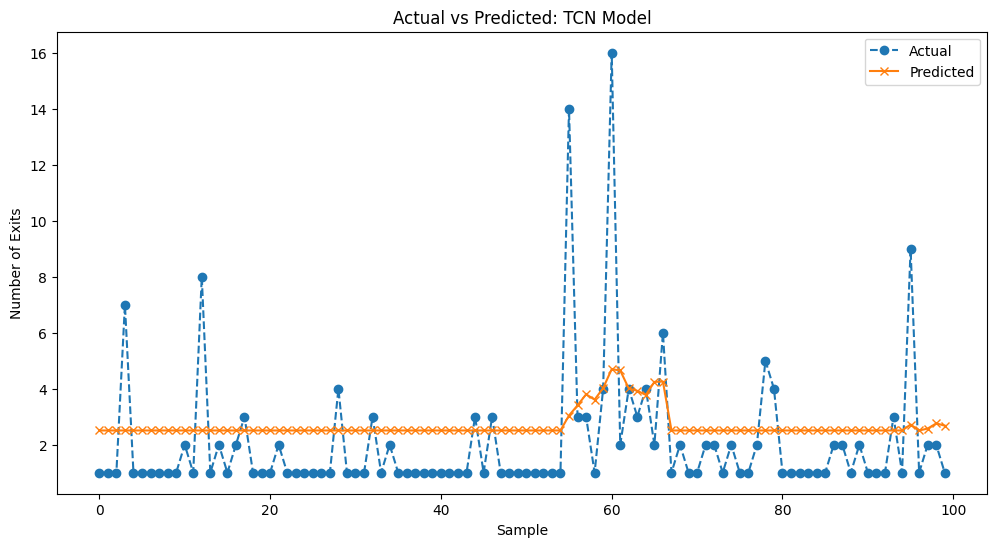

In [30]:
# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled[:100], label='Actual', linestyle='--', marker='o')
plt.plot(y_pred_rescaled[:100], label='Predicted', linestyle='-', marker='x')
plt.title('Actual vs Predicted: TCN Model')
plt.xlabel('Sample')
plt.ylabel('Number of Exits')
plt.legend()
plt.show()

In [31]:
# Save the model
tcn_model_post.save('tcn_model_post.h5')

In [32]:
from google.colab import files

# Download the model file
files.download('tcn_model_post.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Pre Covid Data

In [33]:
# Updated preprocessing function
def preprocess_data_tcn(df):
    # Selected features based on analysis
    features = [
        'hour', 'Origin Station', 'Destination Station', 'temperature_2m',
        'precipitation', 'wind_speed_10m', 'relative_humidity_2m',
        'weekend_service', 'ridership_lag_1', 'ridership_7d_avg'
    ]
    target = 'Number of Exits'

    # Select features and target variable
    X = df[features].values
    y = df[target].values

    # Scale the features and target
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

    # Split into training and testing sets (time-series split)
    split_index = int(len(X_scaled) * 0.8)
    X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
    y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]

    # Reshape features for Conv1D (samples, timesteps, features)
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    return X_train, X_test, y_train, y_test, scaler_X, scaler_y

# Apply preprocessing
X_train, X_test, y_train, y_test, scaler_X, scaler_y = preprocess_data_tcn(pre_covid_data)

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam

# Build TCN model
def build_tcn_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        Dropout(0.2),
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        Dropout(0.2),
        Flatten(),
        Dense(50, activation='relu'),
        Dropout(0.2),
        Dense(1)  # Output layer for regression
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Get input shape for Conv1D
input_shape = (X_train.shape[1], X_train.shape[2])

# Build the TCN model
tcn_model_pre = build_tcn_model(input_shape)

# Train the TCN model
print("Training the TCN model...")
history_tcn_pre = tcn_model_pre.fit(
    X_train, y_train,
    epochs=5,  # Adjust based on needs
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)

Training the TCN model...
Epoch 1/5
273452/273452 ━━━━━━━━━━━━━━━━━━━━ 527s 2ms/step - loss: 0.0026 - val_loss: 3.7317e-04
Epoch 2/5
273452/273452 ━━━━━━━━━━━━━━━━━━━━ 520s 2ms/step - loss: 4.2302e-04 - val_loss: 2.5572e-04
Epoch 3/5
273452/273452 ━━━━━━━━━━━━━━━━━━━━ 521s 2ms/step - loss: 3.6617e-04 - val_loss: 2.3567e-04
Epoch 4/5
273452/273452 ━━━━━━━━━━━━━━━━━━━━ 522s 2ms/step - loss: 3.5009e-04 - val_loss: 2.4508e-04
Epoch 5/5
273452/273452 ━━━━━━━━━━━━━━━━━━━━ 521s 2ms/step - loss: 3.4017e-04 - val_loss: 2.2740e-04


In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict on test data
y_pred = tcn_model_pre.predict(X_test)

# Rescale predictions and actuals back to original scale
y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mape = np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / y_test_rescaled)) * 100

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")

136726/136726 ━━━━━━━━━━━━━━━━━━━━ 157s 1ms/step
RMSE: 17.552901883911648
MAE: 8.57630345909315
MAPE: 289.14%


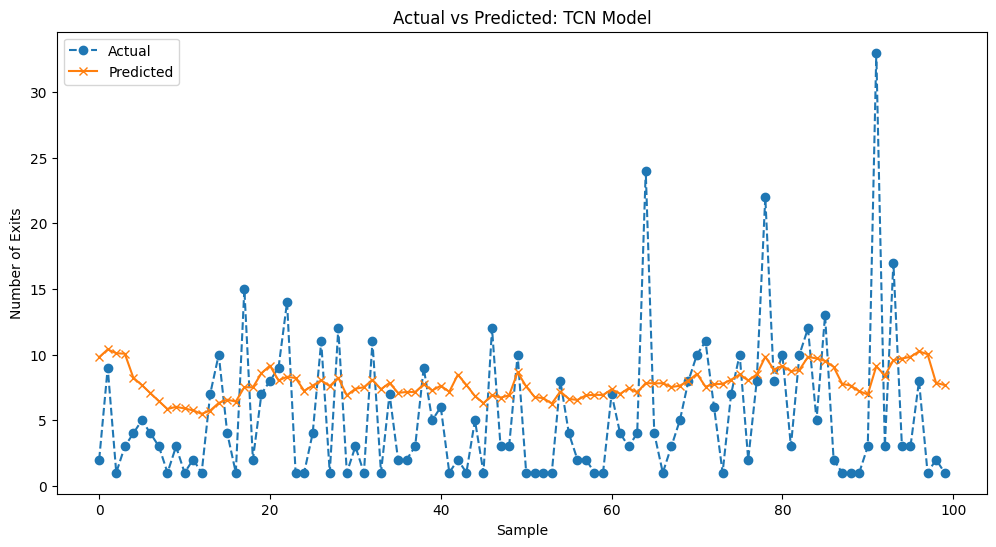

In [36]:
# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled[:100], label='Actual', linestyle='--', marker='o')
plt.plot(y_pred_rescaled[:100], label='Predicted', linestyle='-', marker='x')
plt.title('Actual vs Predicted: TCN Model')
plt.xlabel('Sample')
plt.ylabel('Number of Exits')
plt.legend()
plt.show()

In [37]:
# Save the model
tcn_model_pre.save('tcn_model_pre.h5')

In [38]:
from google.colab import files

# Download the model file
files.download('tcn_model_pre.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Re

In [26]:
# Updated preprocessing function
def preprocess_data_tcn(df):
    # Selected features based on analysis
    features = [
        'hour', 'Origin Station', 'Destination Station', 'temperature_2m',
        'precipitation', 'wind_speed_10m', 'relative_humidity_2m',
        'weekend_service'
    ]
    target = 'Number of Exits'

    # Select features and target variable
    X = df[features].values
    y = df[target].values

    # Scale the features and target
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

    # Split into training and testing sets (time-series split)
    split_index = int(len(X_scaled) * 0.8)
    X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
    y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]

    # Reshape features for Conv1D (samples, timesteps, features)
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    return X_train, X_test, y_train, y_test, scaler_X, scaler_y

# Apply preprocessing
X_train, X_test, y_train, y_test, scaler_X, scaler_y = preprocess_data_tcn(post_covid_data)

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam

# Build TCN model
def build_tcn_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        Dropout(0.2),
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        Dropout(0.2),
        Flatten(),
        Dense(50, activation='relu'),
        Dropout(0.2),
        Dense(1)  # Output layer for regression
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Get input shape for Conv1D
input_shape = (X_train.shape[1], X_train.shape[2])

# Build the TCN model
tcn_model_post = build_tcn_model(input_shape)

# Train the TCN model
print("Training the TCN model...")
history_tcn_post = tcn_model_post.fit(
    X_train, y_train,
    epochs=5,  # Adjust based on needs
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)

Training the TCN model...
Epoch 1/5
347644/347644 ━━━━━━━━━━━━━━━━━━━━ 633s 2ms/step - loss: 0.0015 - val_loss: 1.1739e-04
Epoch 2/5
347644/347644 ━━━━━━━━━━━━━━━━━━━━ 628s 2ms/step - loss: 6.8032e-05 - val_loss: 1.1873e-04
Epoch 3/5
347644/347644 ━━━━━━━━━━━━━━━━━━━━ 627s 2ms/step - loss: 6.7655e-05 - val_loss: 1.1469e-04
Epoch 4/5
347644/347644 ━━━━━━━━━━━━━━━━━━━━ 623s 2ms/step - loss: 6.7263e-05 - val_loss: 1.1609e-04
Epoch 5/5
347644/347644 ━━━━━━━━━━━━━━━━━━━━ 624s 2ms/step - loss: 6.7374e-05 - val_loss: 1.1003e-04


In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict on test data
y_pred = tcn_model_post.predict(X_test)

# Rescale predictions and actuals back to original scale
y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mape = np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / y_test_rescaled)) * 100

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")

173822/173822 ━━━━━━━━━━━━━━━━━━━━ 196s 1ms/step
RMSE: 10.793458405865584
MAE: 4.939929218250382
MAPE: 178.50%


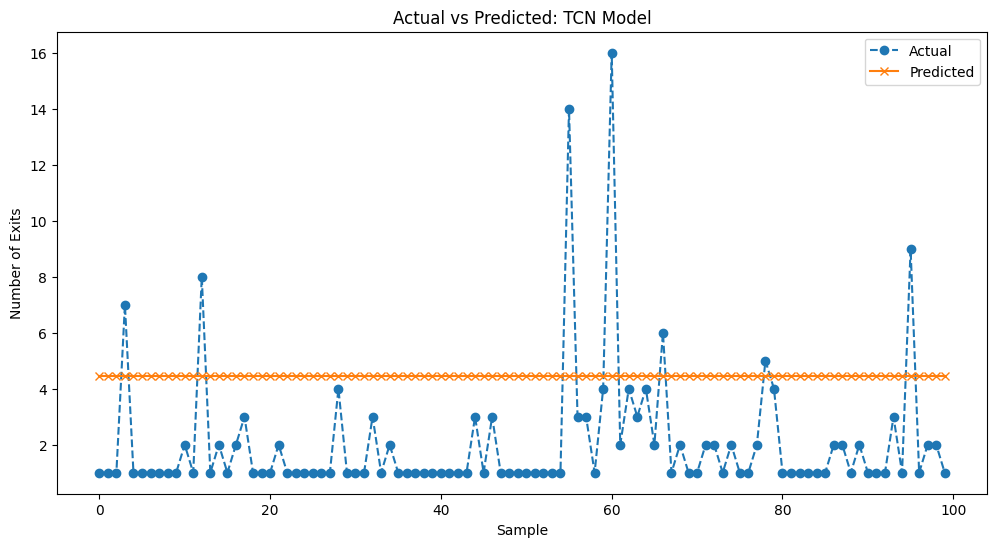

In [29]:
# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled[:100], label='Actual', linestyle='--', marker='o')
plt.plot(y_pred_rescaled[:100], label='Predicted', linestyle='-', marker='x')
plt.title('Actual vs Predicted: TCN Model')
plt.xlabel('Sample')
plt.ylabel('Number of Exits')
plt.legend()
plt.show()

In [30]:
# Save the model
tcn_model_post.save('tcn_model_post_re.h5')

In [31]:
from google.colab import files

# Download the model file
files.download('tcn_model_post_re.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Pre Covid Data

In [32]:
# Updated preprocessing function
def preprocess_data_tcn(df):
    # Selected features based on analysis
    features = [
        'hour', 'Origin Station', 'Destination Station', 'temperature_2m',
        'precipitation', 'wind_speed_10m', 'relative_humidity_2m',
        'weekend_service'
    ]
    target = 'Number of Exits'

    # Select features and target variable
    X = df[features].values
    y = df[target].values

    # Scale the features and target
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

    # Split into training and testing sets (time-series split)
    split_index = int(len(X_scaled) * 0.8)
    X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
    y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]

    # Reshape features for Conv1D (samples, timesteps, features)
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    return X_train, X_test, y_train, y_test, scaler_X, scaler_y

# Apply preprocessing
X_train, X_test, y_train, y_test, scaler_X, scaler_y = preprocess_data_tcn(pre_covid_data)

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam

# Build TCN model
def build_tcn_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        Dropout(0.2),
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        Dropout(0.2),
        Flatten(),
        Dense(50, activation='relu'),
        Dropout(0.2),
        Dense(1)  # Output layer for regression
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Get input shape for Conv1D
input_shape = (X_train.shape[1], X_train.shape[2])

# Build the TCN model
tcn_model_pre = build_tcn_model(input_shape)

# Train the TCN model
print("Training the TCN model...")
history_tcn_pre = tcn_model_pre.fit(
    X_train, y_train,
    epochs=5,  # Adjust based on needs
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)

Training the TCN model...
Epoch 1/5
273452/273452 ━━━━━━━━━━━━━━━━━━━━ 521s 2ms/step - loss: 0.0030 - val_loss: 6.2716e-04
Epoch 2/5
273452/273452 ━━━━━━━━━━━━━━━━━━━━ 512s 2ms/step - loss: 6.9693e-04 - val_loss: 6.1259e-04
Epoch 3/5
273452/273452 ━━━━━━━━━━━━━━━━━━━━ 512s 2ms/step - loss: 6.9385e-04 - val_loss: 6.2105e-04
Epoch 4/5
273452/273452 ━━━━━━━━━━━━━━━━━━━━ 513s 2ms/step - loss: 6.9538e-04 - val_loss: 6.0960e-04
Epoch 5/5
273452/273452 ━━━━━━━━━━━━━━━━━━━━ 510s 2ms/step - loss: 6.9109e-04 - val_loss: 6.3631e-04


In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict on test data
y_pred = tcn_model_pre.predict(X_test)

# Rescale predictions and actuals back to original scale
y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mape = np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / y_test_rescaled)) * 100

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")

136726/136726 ━━━━━━━━━━━━━━━━━━━━ 159s 1ms/step
RMSE: 29.36207561864601
MAE: 12.799394829813384
MAPE: 414.26%


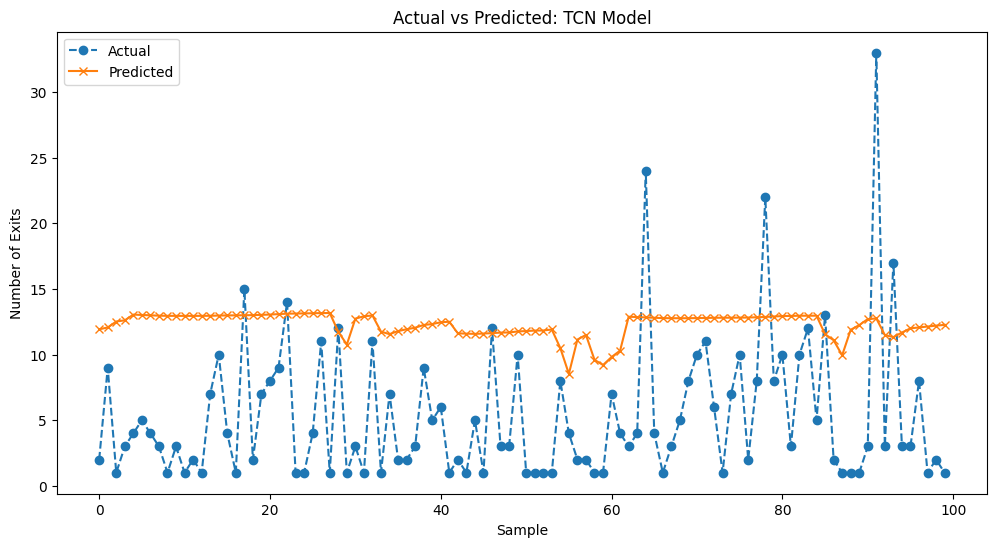

In [35]:
# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled[:100], label='Actual', linestyle='--', marker='o')
plt.plot(y_pred_rescaled[:100], label='Predicted', linestyle='-', marker='x')
plt.title('Actual vs Predicted: TCN Model')
plt.xlabel('Sample')
plt.ylabel('Number of Exits')
plt.legend()
plt.show()

In [36]:
# Save the model
tcn_model_pre.save('tcn_model_pre_re.h5')

In [37]:
from google.colab import files

# Download the model file
files.download('tcn_model_pre_re.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>